In [29]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib
import scipy.stats

matplotlib.rcParams.update({'font.size': 26})

import sys
sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

from misc import pearson_r, get_best_models, highlight_ns, model_alias, model_bar_colors, dna_models

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def compute_score_folds(x):
    df = len(x)-1 #number of folds minus 1
    ci_95 = scipy.stats.t.interval(0.95, df, loc=np.mean(x), scale=np.std(x))
    pearson_r = np.mean(x)
    ci_95 = np.diff(ci_95)[0]/2
    return (pearson_r, ci_95)

In [31]:
project_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

## Combine regression output

### 3'UTR-only models

In [32]:
models = ['DNABERT','DNBT-3UTR-RNA','DNABERT2','DNABERT2-ZOO','DNBT2-3UTR-RNA','NT-MS-v2-100M',
         'NT-3UTR-RNA','STSP-3UTR-RNA','STSP-3UTR-RNA-SA','STSP-3UTR-DNA','STSP-3UTR-RNA-HS','k-mer']

In [33]:
transcript_to_gene = pd.read_csv(project_dir + 'UTR_coords/GRCh38_EnsembleCanonical_HGNC.tsv.gz', sep='\t', 
                                     names=['gene','transcript_id'], skiprows=1,usecols=[0,1])

utr_ids = pd.read_csv(project_dir + 'UTR_coords/GRCh38_3_prime_UTR_clean.bed', sep='\t',usecols=[3,5], names = ['UTR_ID','strand'])
utr_ids['transcript_id'] = utr_ids.UTR_ID.apply(lambda x:x.split('.')[0])
gene_to_utr = transcript_to_gene.merge(utr_ids).drop_duplicates()

res = []

for regressor in ('Ridge','SVR'):
    print(regressor)
    results_dir = project_dir + f'half_life/agarwal_2022/predictions/{regressor}/'
    for model in models:
            res_tsv = results_dir + f'{model_alias[model]}.tsv'
            if os.path.isfile(res_tsv):
                    df = pd.read_csv(res_tsv, sep='\t')
                    df['model'] = model
                    df['regressor'] = regressor
                    res.append(df)

res = pd.concat(res)
res = res.merge(gene_to_utr)

Ridge
SVR


In [34]:
res.loc[res.model.isin(dna_models),'fasta_file'] = 'fasta/Homo_sapiens_dna_fwd.fa'
res.loc[~res.model.isin(dna_models),'fasta_file'] = 'fasta/Homo_sapiens_rna.fa'

In [35]:
#number of targets

res.UTR_ID.nunique()

12457

In [36]:
res = res[['fold','UTR_ID','gene','strand','regressor','model','y_true','y_pred','fasta_file']]

res.to_csv(project_dir + 'all_scores/half-life.tsv.gz',sep='\t',index=None)

### Full sequence models

In [37]:
fullseq_res = pd.read_csv(project_dir + 'half_life/agarwal_2022/agarwal_data/saluki_paper/Fig5_S6/experimentResults.csv')[['Saluki human','BC3MS']]

BC3MS = pd.read_csv(project_dir + 'half_life/agarwal_2022/predictions/Lasso/BC3MS.tsv',sep='\t')
fullseq_res['BC3MS'] = BC3MS.groupby('fold').apply(lambda x:pearson_r(x.y_true,x.y_pred),include_groups=False)

BC3MS_best_emb = pd.read_csv(project_dir + 'half_life/agarwal_2022/predictions/SVR/BC3MS-dnabert2-3utr-2e.tsv',sep='\t')
fullseq_res['BC3MS*'] = BC3MS_best_emb.groupby('fold').apply(lambda x:pearson_r(x.y_true,x.y_pred),include_groups=False)

fullseq_res.rename(columns={'Saluki human':'Saluki human'},inplace=True)
fullseq_res.index.name = 'fold'

In [38]:
fullseq_res.to_csv(project_dir + 'all_scores/half-life_fullseq.tsv.gz',sep='\t')

## Compute summary statistics

In [39]:
models = ['DNABERT','DNBT-3UTR-RNA','DNABERT2','DNABERT2-ZOO','DNBT2-3UTR-RNA','NT-MS-v2-100M',
         'NT-3UTR-RNA','STSP-3UTR-RNA','STSP-3UTR-RNA-HS','STSP-3UTR-DNA','k-mer']

In [40]:
res = pd.read_csv(project_dir + 'all_scores/half-life.tsv.gz',sep='\t')

res = res[res.model.isin(models)]

In [41]:
#3'UTR table

#utr_table = pd.read_csv(project_dir + 'UTR_coords/GRCh38_3_prime_UTR_clean-sorted.bed', sep='\t',
#                       header = None, names=['seq_start','seq_end','UTR_ID','strand'], usecols=[1,2,3,5])
#utr_table['utr_len'] = utr_table.seq_end - utr_table.seq_start
#res = res.merge(utr_table[['utr_len','UTR_ID','strand']])

In [42]:
scores_df = res.groupby(['regressor','model']).apply(lambda x:pearson_r(x.y_true,x.y_pred,compute_CI=True),include_groups=False).rename('pearson_r').reset_index()
scores_df.pearson_r = scores_df.pearson_r.apply(lambda x: (round(x[0],2),round(x[1],2)))

best_models = scores_df.set_index('model').groupby('regressor').pearson_r.apply(get_best_models)
scores_df = scores_df.pivot(index=['model'],columns=['regressor']).droplevel(0,axis=1)
scores_df = scores_df.loc[models]

In [43]:
scores_df.map(lambda x: f'{x[0]:.2f}±{x[1]:.2f}' if isinstance(x,tuple) else 'none').style.apply(lambda x: highlight_ns(x, best_models))

regressor,Ridge,SVR
model,,
DNABERT,0.30±0.02,0.32±0.02
DNBT-3UTR-RNA,0.41±0.01,0.41±0.01
DNABERT2,0.32±0.02,0.35±0.02
DNABERT2-ZOO,0.30±0.02,0.36±0.02
DNBT2-3UTR-RNA,0.43±0.01,0.45±0.01
NT-MS-v2-100M,0.32±0.02,0.34±0.02
NT-3UTR-RNA,0.42±0.01,0.45±0.01
STSP-3UTR-RNA,0.36±0.02,0.38±0.02
STSP-3UTR-RNA-HS,0.33±0.01,0.34±0.01


In [44]:
fullseq_res = pd.read_csv(project_dir + 'all_scores/half-life_fullseq.tsv.gz',sep='\t',index_col=0)

In [45]:
scores_fullseq = fullseq_res.apply(compute_score_folds).T
scores_fullseq.apply(lambda x:f'{x[0]:.2f}±{x[1]:.2f}',axis=1)

Saluki human    0.77±0.03
BC3MS           0.67±0.04
BC3MS*          0.69±0.03
dtype: object

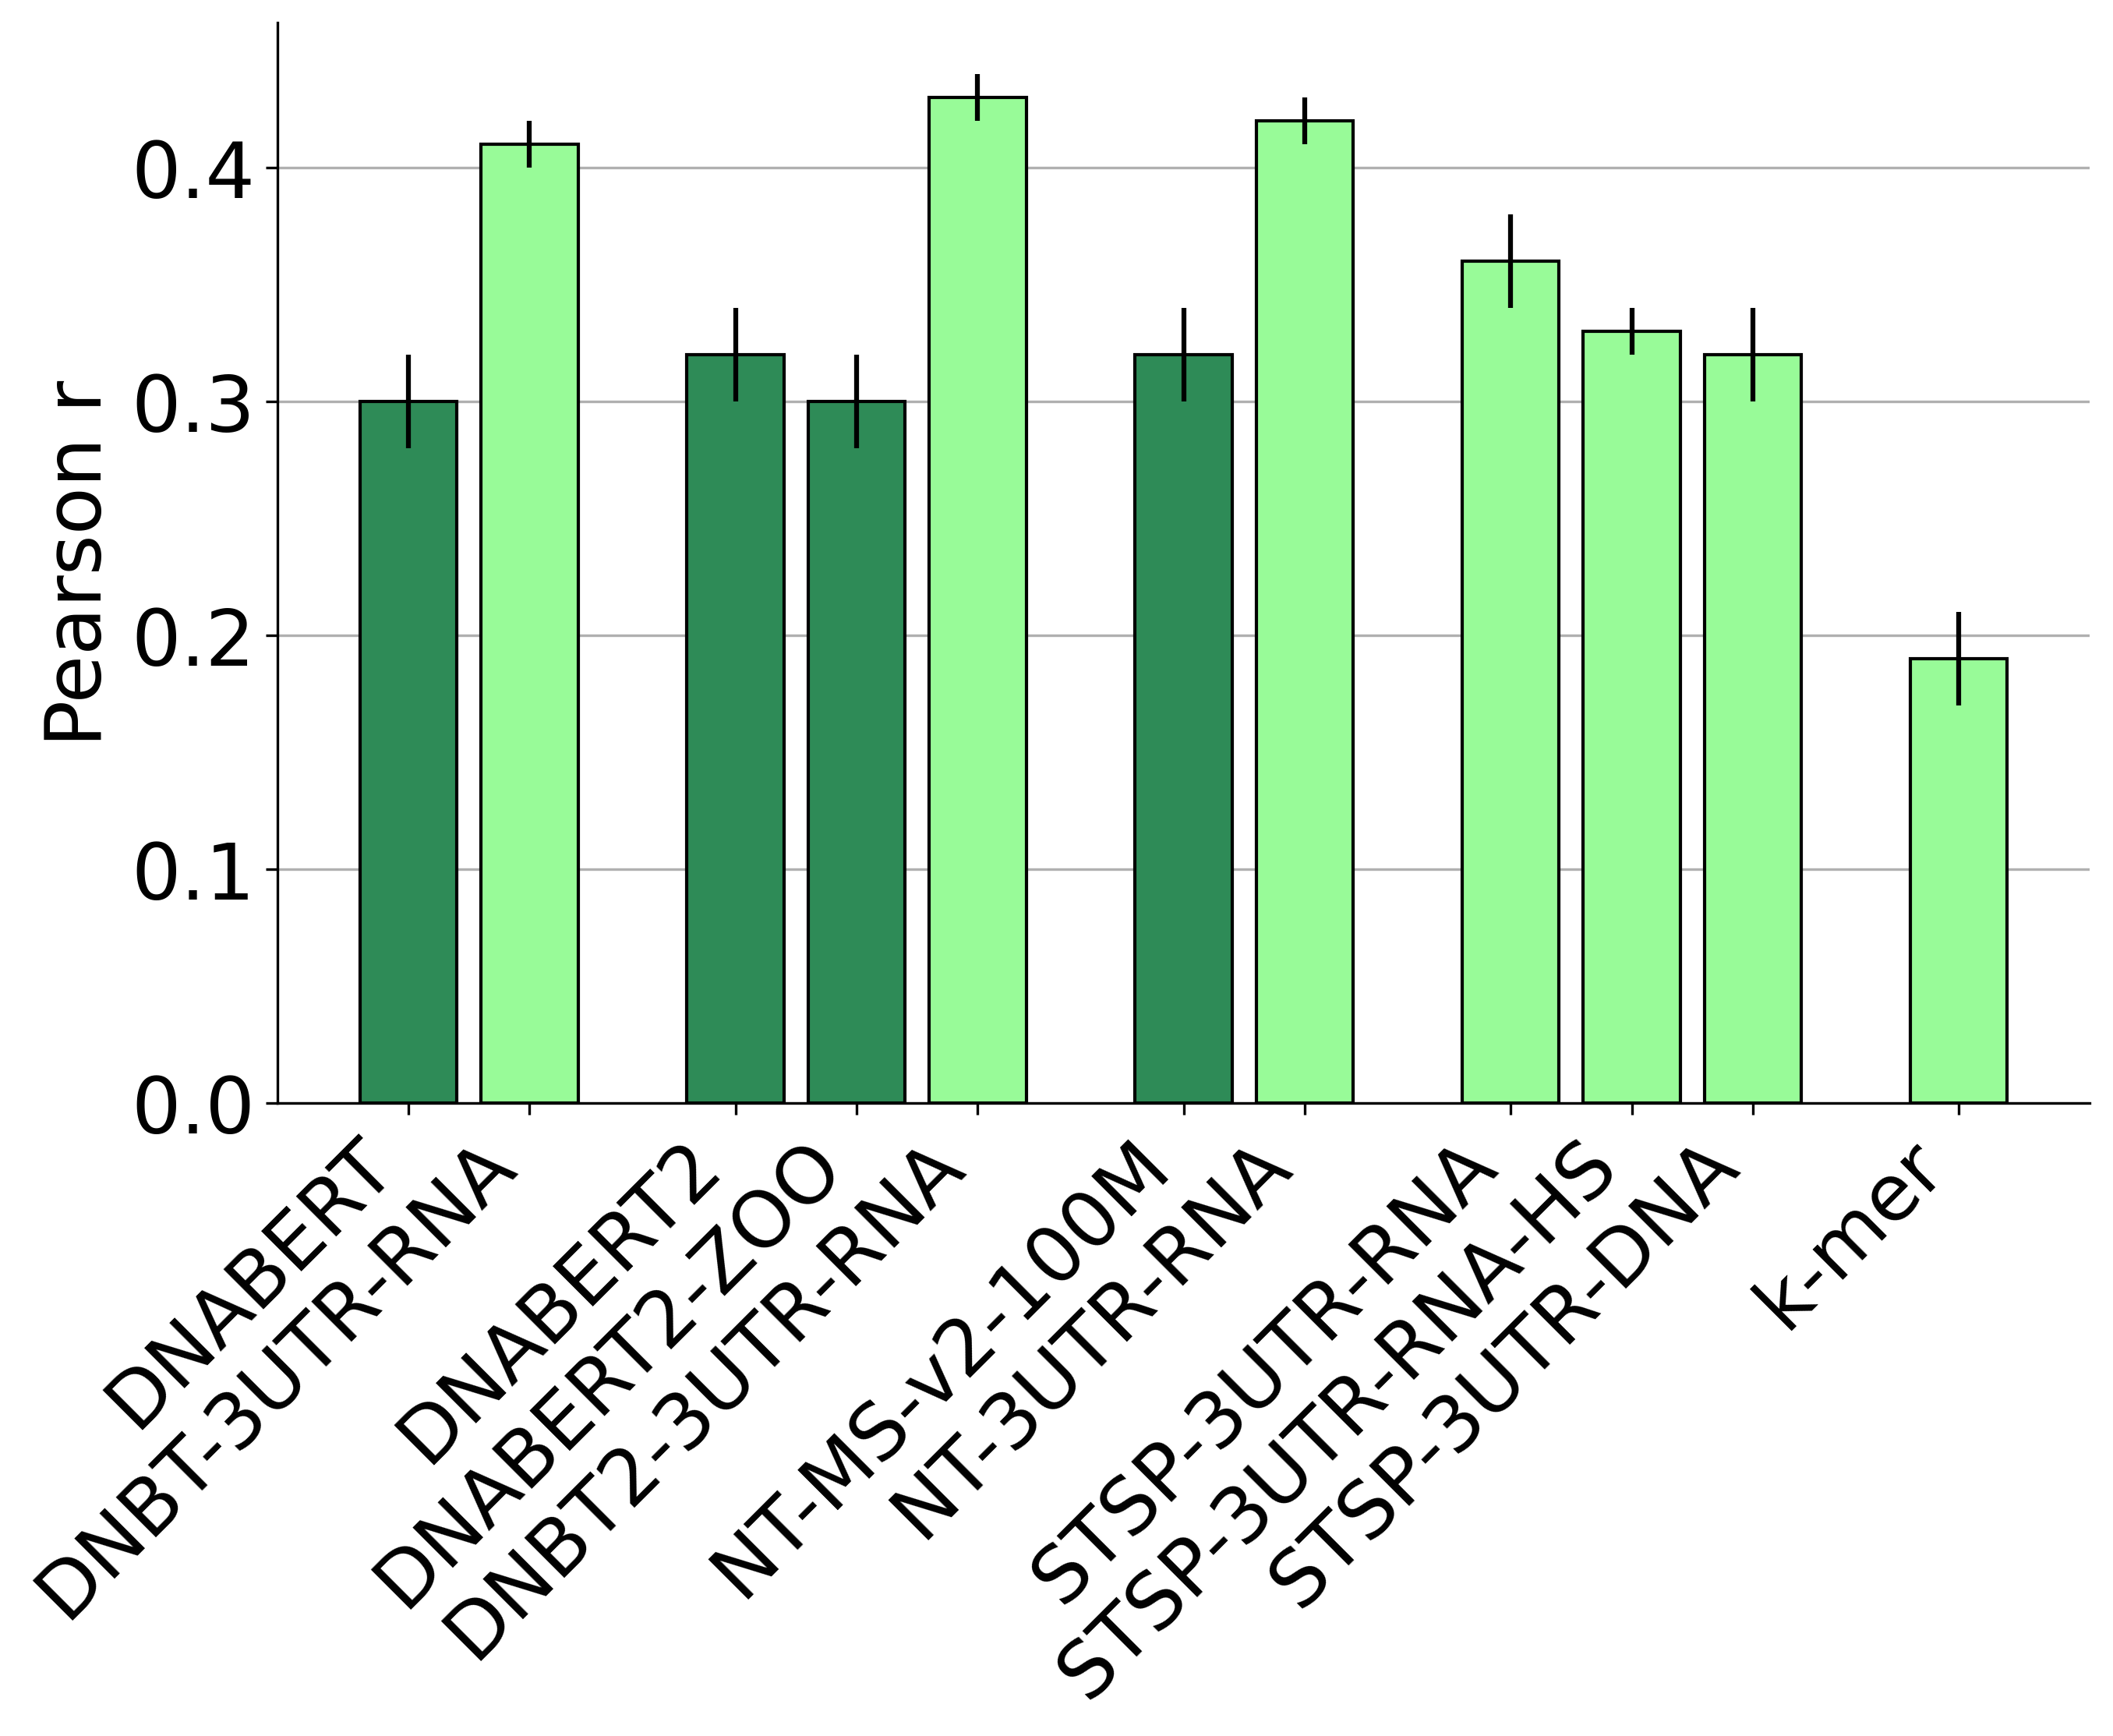

In [46]:
df = scores_df.Ridge

matplotlib.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(dpi=300, figsize=(10,6))

offset = 0

xticks = []
for idx, (model, corr) in enumerate(df.items()):
    if model in ('DNABERT2','NT-MS-v2-100M','STSP-3UTR-RNA','k-mer'):
        offset+=0.7
    ax.bar(offset+idx, corr[0], yerr=corr[1], color=model_bar_colors[model], edgecolor='black')
    xticks.append(offset+idx)

ax.grid(axis='y')
ax.set_axisbelow(True)
    
ax.set_xticks(xticks, df.index, rotation=45, ha="right");

ax.set_ylabel('Pearson r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

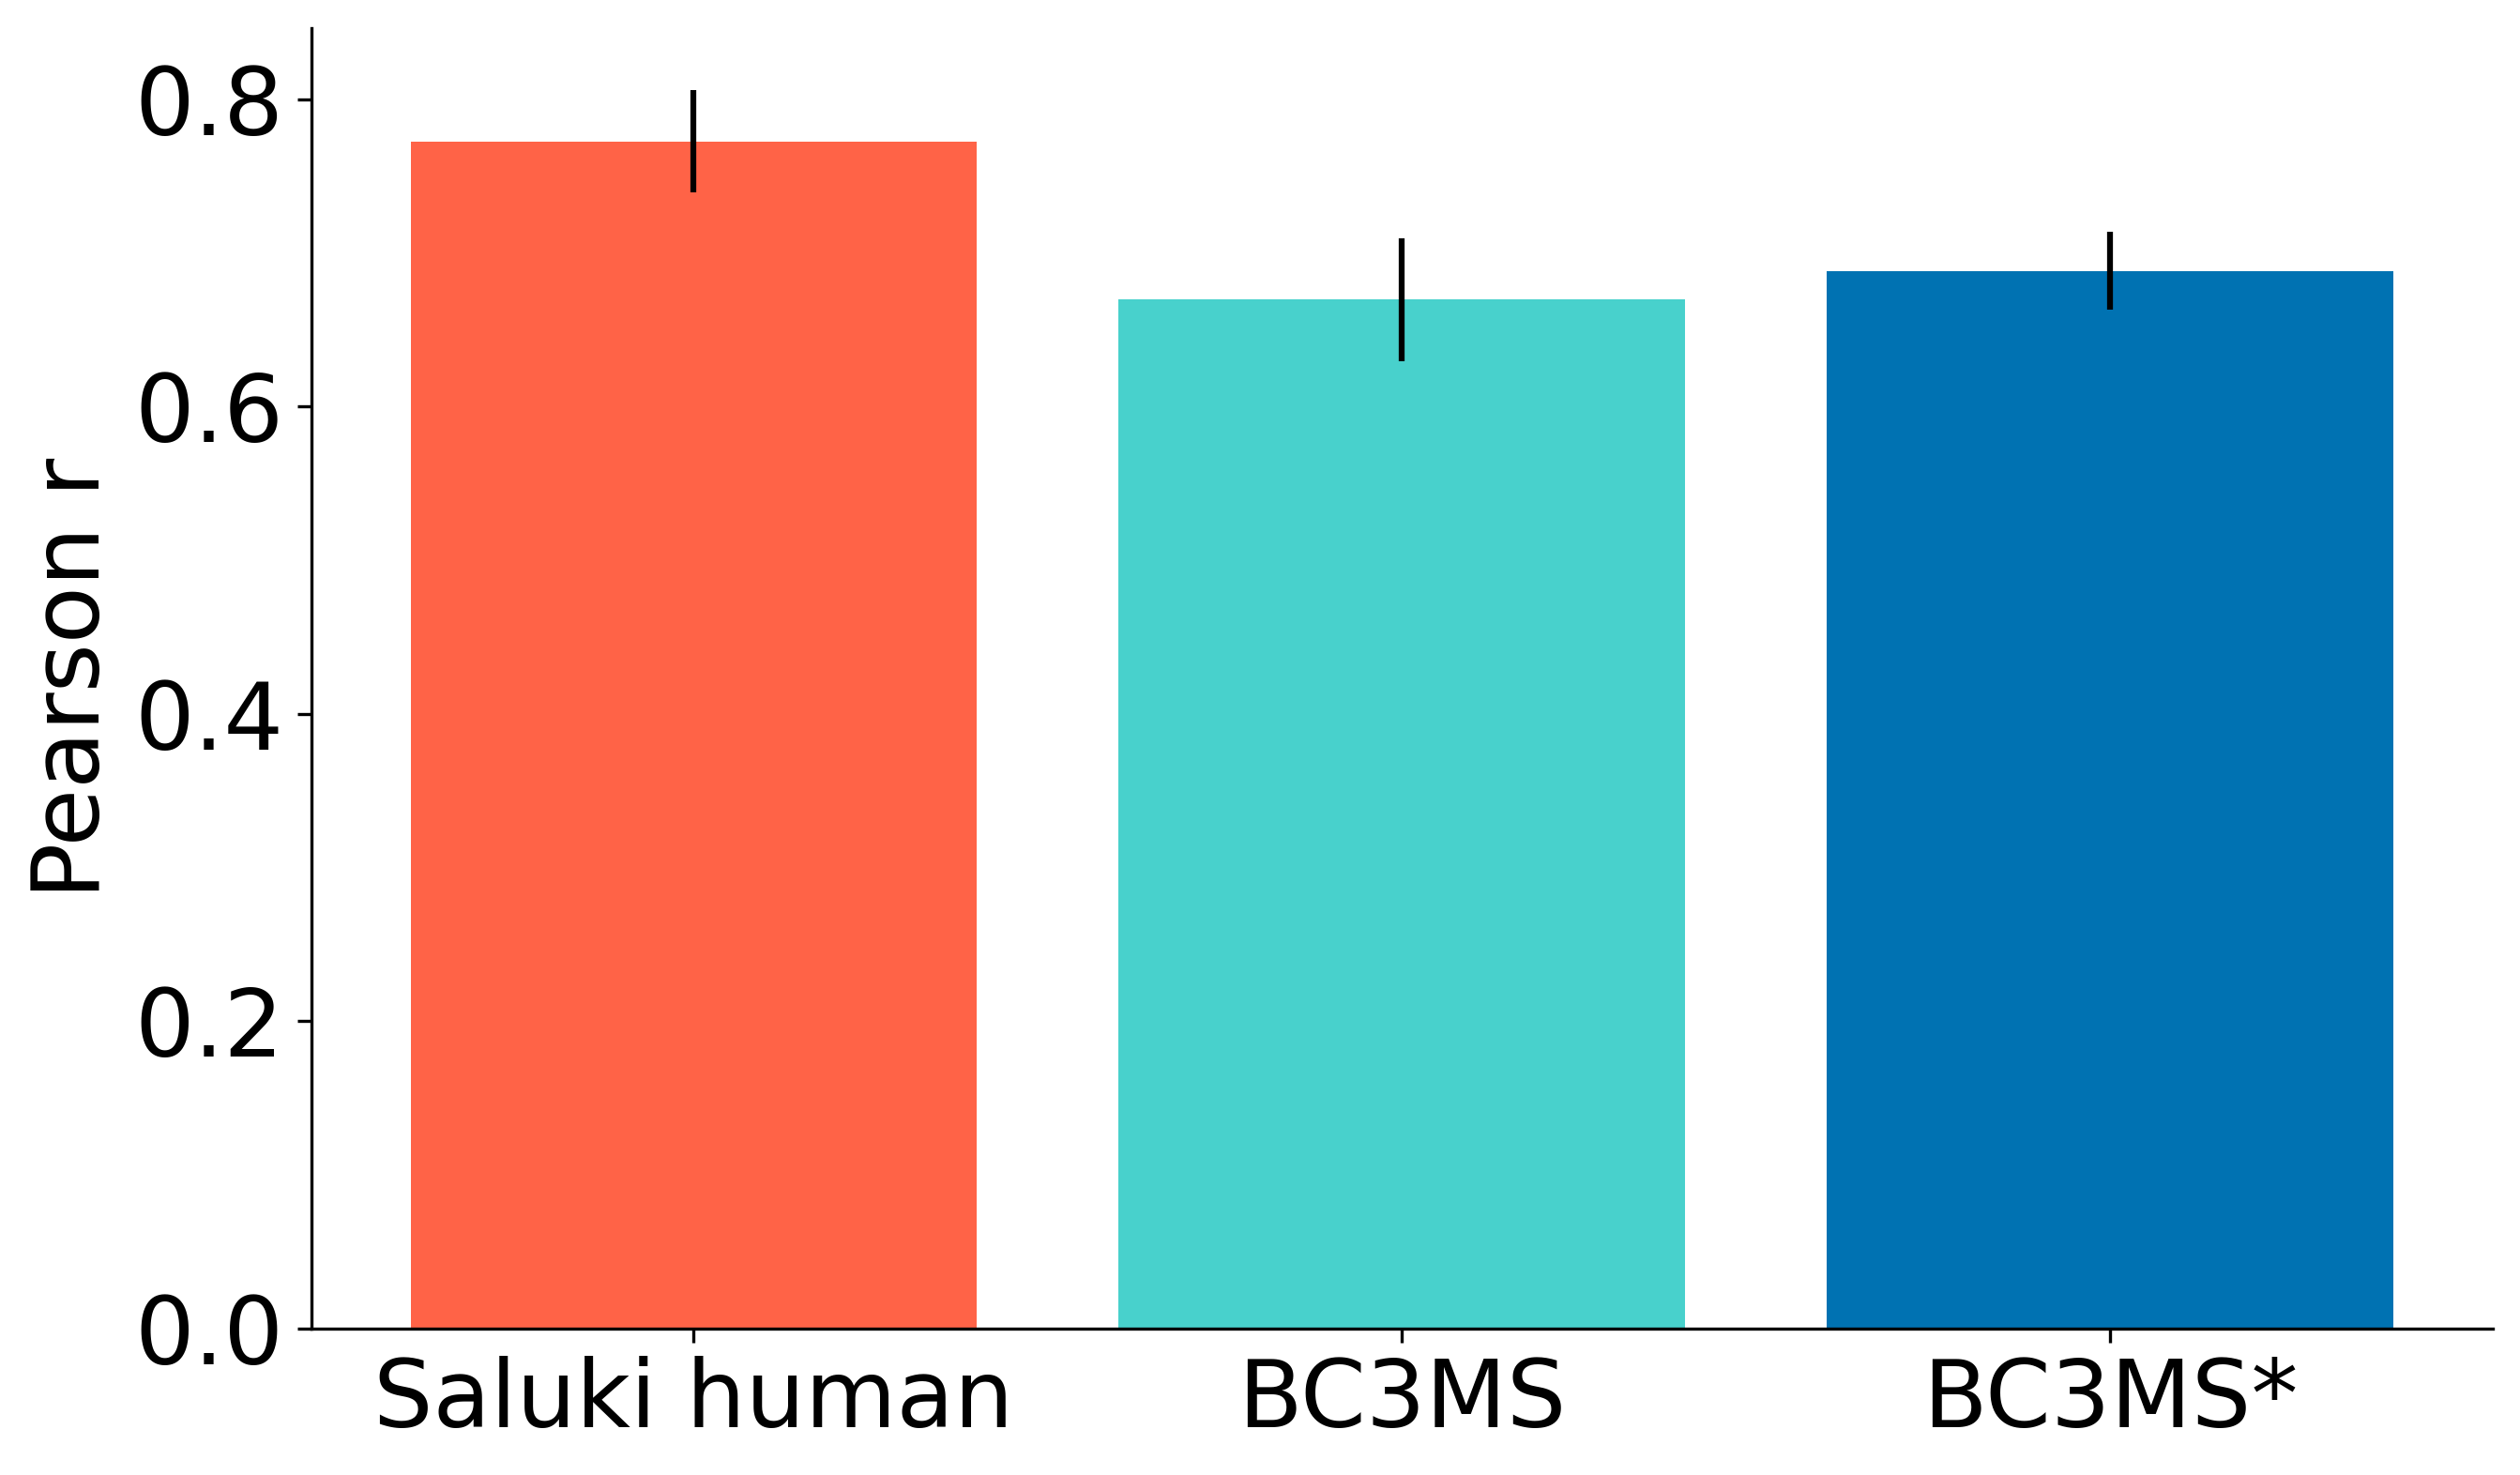

In [19]:
fig, ax = plt.subplots(dpi=300, figsize=(10,6))

pearson, ci_95 = zip(*scores_fullseq.values.tolist())

ax.bar(scores_fullseq.index, pearson, yerr=ci_95, color=scores_fullseq.index.map(model_bar_colors))
ax.set_ylabel('Pearson r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Performance vs seq length

In [22]:
seq_len_model = 'NT-3UTR-RNA'

In [23]:
seqlen_res = []

for regressor in ('Ridge','SVR'):
    print(regressor)
    results_dir = project_dir + f'half_life/agarwal_2022/seqlen-exp/predictions/{regressor}/'
    for max_seq_len in (512,1024,2048,4096):        
            res_tsv = results_dir + f'{model_alias[seq_len_model]}-{max_seq_len}.tsv'
            if os.path.isfile(res_tsv):
                    df = pd.read_csv(res_tsv, sep='\t')
                    df['max_seq_len'] = max_seq_len
                    df['regressor'] = regressor
                    seqlen_res.append(df)

seqlen_res = pd.concat(seqlen_res)
seqlen_res['model'] = seq_len_model
seqlen_res.max_seq_len = seqlen_res.max_seq_len.astype(str)

Ridge
SVR


In [24]:
seqlen_res = pd.concat([seqlen_res,
                        res.loc[res.model==seq_len_model,
                            ['fold','gene','y_true','y_pred','regressor','model']]
                       ])

seqlen_res.max_seq_len = seqlen_res.max_seq_len.fillna("whole 3'UTR")

In [25]:
scores_df = seqlen_res.groupby(['regressor','max_seq_len'], sort=False).apply(lambda x:pearson_r(x.y_true,x.y_pred,compute_CI=True),include_groups=False).rename('pearson_r').reset_index()
scores_df.pearson_r = scores_df.pearson_r.apply(lambda x: (round(x[0],2),round(x[1],2)))

In [26]:
idx = scores_df.max_seq_len.drop_duplicates().values

In [27]:
scores_df = scores_df.pivot(index=['max_seq_len'],columns=['regressor']).droplevel(0,axis=1).loc[idx]
scores_df.map(lambda x:f'{x[0]:.2f}±{x[1]:.2f}')

regressor,Ridge,SVR
max_seq_len,,
512,0.38±0.02,0.41±0.01
1024,0.40±0.01,0.43±0.01
2048,0.41±0.01,0.45±0.01
4096,0.41±0.01,0.45±0.01
whole 3'UTR,0.42±0.01,0.45±0.01
